**The battle of the neighborhoods**
==============

# Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# 1. Introduction: Business Problem <a name='introduction'></a>
Philadelphia, Pennsylvania’s largest city, is one of the most historic cities in America. Philadelphia has been in the forefront of the nation's intellectual, economic, and humanitarian development for more than three hundred years. Philadelphia offers the advantages of living in a big city while maintaining a small-town atmosphere and preserving reminders of its dignified past. The Greater Philadelphia area has been on numerous best city lists as a good place to balance work and family life.

The objective of this capstone project is to analyze and using data science methodology and machine learning techniques like clustering, to provide solutionsmfor what would be a better place to live?

# 2. Data <a name='data'></a>

**[OpenDataPhilly site](https://www.opendataphilly.org/dataset)** is a great repository for information regarding. The most informative datasets I found regarding Philadelphia are the following:

* **[Neighborhoods Data](https://www.opendataphilly.org/dataset/philadelphia-neighborhoods)**: This data set contains 158 neighborhoods of Philadelphia and theirs geographical data. From [Neighborhoods Shapefile](https://github.com/azavea/geo-data), I download and use `Neighborhoods_Philadelphia.geojson` for my location dataset.


* **[Crime Incidents](https://www.opendataphilly.org/dataset/crime-incidents)**: This dataset contains information and geographical location of crime incidents. It can collect thought an [open api](https://cityofphiladelphia.github.io/carto-api-explorer/#incidents_part1_part2).  This crime incidents data come from the Philadelphia Police Department. Crimes include violent offenses such as aggravated assault, rape, arson, simple assault, prostitution, gambling, fraud, and other non-violent offenses.


* **[Venues Data](https://developer.foursquare.com/docs/api-reference/venues/search/)**: I will use Foursquare API to get the venue data for Philly neighborhood and geolocation. 

    
*** Note: *** For later use, reduce the api call, I export data to csv file and put them on `data` folder

In [878]:
import requests

import pandas as pd
import geopandas as gpd
import io
import json

from datetime import datetime, date

from geopy.geocoders import Nominatim
from shapely.geometry import Point, MultiPoint

# Clustering
from sklearn.cluster import KMeans

# Dimensionality reduction
from sklearn.decomposition import PCA

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import folium
from folium import plugins

# config data
from config_file import CLIENT_ID
from config_file import CLIENT_SECRET

# set theme
sns.set_theme(style="whitegrid")
print('Libraries imported.')


Libraries imported.


## 2.1 Get Geographical Locations Data

We load geographical data of Philadelphia and build Philadelphia map with all neighborhoods

In [879]:
# get locator of Philadelphia to generate map
geolocator = Nominatim(user_agent='Philadelphia')
geo_philly = geolocator.geocode('Philadelphia')


In [880]:
# load geographical data
df_philly = gpd.read_file('data/Neighborhoods_Philadelphia.geojson')
# preprocess data, get center point latitude and longitude
df_philly['center_longitude'] = df_philly['geometry'].centroid.x
df_philly['center_latitude'] = df_philly['geometry'].centroid.y
# preprocess data
df_philly = df_philly.sort_values('mapname').reset_index()
df_philly = df_philly.rename(
    columns={'mapname': 'neighborhood'}, inplace=False)
df_philly = df_philly[['neighborhood', 'geometry',
                       'center_latitude', 'center_longitude']]
print(df_philly.shape)
df_philly.head(1)


(158, 4)


<ipython-input-880-e87d661a1c79>:4: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


<ipython-input-880-e87d661a1c79>:5: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




,neighborhood,geometry,center_latitude,center_longitude
0,Academy Gardens,"MULTIPOLYGON (((-75.00719 40.06923, -75.00290 ...",40.061186,-75.003104


In [881]:
# build Philly map
def style_function(x): return {
    'fillColor': '#b0d5ff',
    'color': '#006be6',
    'weight': 2,
    'fillOpacity': 0.5
}


map_philly = folium.Map(location=[geo_philly.latitude, geo_philly.longitude],
                        zoom_start=12, tiles="Stamen Terrain")
folium.GeoJson(
    df_philly,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['neighborhood'],
        labels=False,
        localize=True
    ),
    popup=folium.GeoJsonPopup(fields=['neighborhood'], labels=False)
).add_to(map_philly)

# add neighborhood markers to map
for lat, lng, neighborhood in zip(df_philly['center_latitude'], df_philly['center_longitude'], df_philly['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    icon = folium.DivIcon(
        html=f"""<div style="font-weight: bold; color: #c7580e;">{neighborhood}</div>""")
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=icon).add_to(map_philly)

map_philly


## 2.2 Get Venues Data

In Fourquare API, we have a lot of venue categories, we just use waht needed for our decision. Here are the list of venue categories which we pick for this situation.

In [882]:
# list of category which will collect data
df_venue_categories = pd.read_json('data/venue_categories.json')
df_venue_categories


,id,name,icon,icon_color
0,4d4b7104d754a06370d81259,Arts & Entertainment,film,blue
1,4d4b7105d754a06374d81259,Food,cutlery,orange
2,4bf58dd8d48988d104941735,Medical Center,heart,red
3,4d4b7105d754a06376d81259,Nightlife Spot,glass,darkpuple
4,4d4b7105d754a06378d81259,Shop & Service,shopping-cart,green


Get venues data from Foursquare API and clean venues data.

In [883]:
# Foursquare api
LIMIT = 200
VERSION = '20210605'

# get all nearby venues
def get_nearby_venues(neighborhoods, latitudes, longitudes, category_id, radius=1000):

    venues_list = []
    for neighborhood, lat, lng in zip(neighborhoods, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            category_id,
            radius,
            LIMIT)

        # make the GET request
        results = requests.get(url).json()['response']['venues']

        # return only relevant information for each nearby venue
        venues_list.append([(
            neighborhood,
            v['name'],
            v['location']['lat'],
            v['location']['lng'],
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame(
        [item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighborhood',
                             'venue',
                             'venue_latitude',
                             'venue_longitude',
                             'venue_category']

    return(nearby_venues)

# get all foursquare venues categories
def get_venue_categories():
    url = 'https://api.foursquare.com/v2/venues/categories'
    params = {
        "client_id": CLIENT_ID,
        "client_secret": CLIENT_SECRET,
        "v": VERSION,
    }
    return requests.get(url, params=params).json()["response"]["categories"]


In [884]:
# get all sub categories
def get_sub_categories(node, categories):
    categories.append(node['name'])
    if not node['categories']:
        return
    for sub_node in node['categories']:
        get_sub_categories(sub_node, categories)

# find sub category and return parent category
def find_parent_category(category, categories_list):
    for key in categories_list:
        if category in categories_list[key]:
            return key


Get the foursquare venues categories, then get all nearby venues based on the center point of each neighborhood.

In [885]:
# get all foursquare venues categories to dictionary
foursquare_venue_categories = {}
for sub in get_venue_categories():
    categories = []
    get_sub_categories(sub, categories)
    foursquare_venue_categories[sub['name']] = categories


In [888]:
# get all near by venues for each neighborhood
df_venues = get_nearby_venues(
    neighborhoods=df_philly['neighborhood'],
    latitudes=df_philly['center_latitude'],
    longitudes=df_philly['center_longitude'],
    category_id=','.join(df_venue_categories['id'])
)
print(df_venues.shape)

# clean duplicate data
df_venues.drop_duplicates(keep='first', inplace=True)
print(df_venues.shape)
df_venues.head(1)


(7441, 5)
(7441, 5)


,neighborhood,venue,venue_latitude,venue_longitude,venue_category
0,Academy Gardens,the studio,40.059665,-75.003242,Music Venue


In [889]:
# replace all category with general category for venues
df_venues['venue_category'] = df_venues.apply(
    lambda x: find_parent_category(x['venue_category'], foursquare_venue_categories), axis=1)
print(df_venues.shape)
df_venues.head(1)


(7441, 5)


,neighborhood,venue,venue_latitude,venue_longitude,venue_category
0,Academy Gardens,the studio,40.059665,-75.003242,Arts & Entertainment


In [890]:
# get an overview of venues data
df_venues.groupby(['venue_category']).size().reset_index(name='counts')


,venue_category,counts
0,Arts & Entertainment,545
1,College & University,4
2,Food,2663
3,Nightlife Spot,771
4,Outdoors & Recreation,32
5,Professional & Other Places,515
6,Residence,10
7,Shop & Service,2886
8,Travel & Transport,15


Based on the foursquare venues categories, the `Medical Center` is sub category of `Professional & Other Places`, so we will replace `Professional & Other Places` with `Medical Center` to change it back to the right category.

In [891]:
df_venues['venue_category'] = df_venues['venue_category'].str.replace(
    'Professional & Other Places', 'Medical Center')


In [892]:
# get an overview of venues data
df_venues.groupby(['venue_category']).size().reset_index(name='counts')


,venue_category,counts
0,Arts & Entertainment,545
1,College & University,4
2,Food,2663
3,Medical Center,515
4,Nightlife Spot,771
5,Outdoors & Recreation,32
6,Residence,10
7,Shop & Service,2886
8,Travel & Transport,15


Althogh we used the category id on the foursquare api but the data return still have some bad data. So that we need to remove it.

In [893]:
df_venues = df_venues[df_venues['venue_category'].isin(df_venue_categories['name'])]
df_venues.groupby(['venue_category']).size().reset_index(name='counts')


,venue_category,counts
0,Arts & Entertainment,545
1,Food,2663
2,Medical Center,515
3,Nightlife Spot,771
4,Shop & Service,2886


In [894]:
# merge data frame
df_venues = pd.merge(df_venues, df_venue_categories,
                     left_on='venue_category', right_on='name', how="inner")
# drop unuse columns
df_venues.drop(columns=['id', 'name'], inplace=True)
print(df_venues.shape)
df_venues.head(1)


(7380, 7)


,neighborhood,venue,venue_latitude,venue_longitude,venue_category,icon,icon_color
0,Academy Gardens,the studio,40.059665,-75.003242,Arts & Entertainment,film,blue


In [895]:
# drop all NaN values
df_venues.dropna()
df_venues.shape

(7380, 7)

Finish get and clean data, now we export data to csv file for later use.

In [896]:
# export to csv file for later use
df_venues.to_csv('data/df_venues.csv', index=False)

## 2.3 Get Crime Data

The API that using for getting crime data support date range parameter, so we define the number of years which want to collect data then parsing the `from date`, `to date` to request parameter to collect data.

We don't have full year data of current year, so we start with previous year.

In [897]:
# change the range of data collected
NUMBER_OF_YEAR = 5

# get api url
current_year = datetime.now().year
crime_url = "https://phl.carto.com/api/v2/sql?filename=incidents_part1_part2&format=csv&q=SELECT * , ST_Y(the_geom) AS lat, ST_X(the_geom) AS lng, round(ST_Area(the_geom::geography)) AS geography_area, round(ST_Area(the_geom_webmercator)) AS area FROM incidents_part1_part2 WHERE dispatch_date_time >= '{}-01-01' AND dispatch_date_time < '{}-01-01'".format(
    current_year - NUMBER_OF_YEAR, current_year)

# download and load data
crime_response = requests.get(crime_url).content
df_crime_raw = pd.read_csv(io.StringIO(
    crime_response.decode('utf-8')), dtype={"dc_dist": int})
print(df_crime_raw.shape)
df_crime_raw.head(2)


/Users/nguyenho/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning:

Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.



(769492, 20)


,the_geom,cartodb_id,the_geom_webmercator,objectid,dc_dist,psa,dispatch_date_time,dispatch_date,dispatch_time,hour_,dc_key,location_block,ucr_general,text_general_code,point_x,point_y,lat,lng,geography_area,area
0,0101000020E61000002FD31F2F1ECE52C07129BE0C0CF5...,11,0101000020110F0000401FFA8143F15FC1160AD2D2C283...,117,12,1,2018-01-06 10:56:00,2018-01-06,10:56:00,10.0,201812001185,6600 BLOCK ESSINGTON AVE,600,Thefts,-75.220592,39.91443,39.91443,-75.220592,0.0,0.0
1,0101000020E61000002FD31F2F1ECE52C07129BE0C0CF5...,12,0101000020110F0000401FFA8143F15FC1160AD2D2C283...,118,12,1,2018-06-21 22:57:00,2018-06-21,22:57:00,22.0,201812045738,6600 BLOCK ESSINGTON AVE,300,Robbery Firearm,-75.220592,39.91443,39.91443,-75.220592,0.0,0.0


Because of the big number of data returned, so we store it on csv file for later use.

In [898]:
# store crime data for later use
df_crime_raw.to_csv('data/df_crime_raw.csv', index=False)


In [899]:
# load crime data from saved file
df_crime_raw = pd.read_csv('data/df_crime_raw.csv')
print(df_crime_raw.shape)
df_crime_raw.head(2)


/Users/nguyenho/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning:

Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.



(769492, 20)


,the_geom,cartodb_id,the_geom_webmercator,objectid,dc_dist,psa,dispatch_date_time,dispatch_date,dispatch_time,hour_,dc_key,location_block,ucr_general,text_general_code,point_x,point_y,lat,lng,geography_area,area
0,0101000020E61000002FD31F2F1ECE52C07129BE0C0CF5...,11,0101000020110F0000401FFA8143F15FC1160AD2D2C283...,117,12,1,2018-01-06 10:56:00,2018-01-06,10:56:00,10.0,201812001185,6600 BLOCK ESSINGTON AVE,600,Thefts,-75.220592,39.91443,39.91443,-75.220592,0.0,0.0
1,0101000020E61000002FD31F2F1ECE52C07129BE0C0CF5...,12,0101000020110F0000401FFA8143F15FC1160AD2D2C283...,118,12,1,2018-06-21 22:57:00,2018-06-21,22:57:00,22.0,201812045738,6600 BLOCK ESSINGTON AVE,300,Robbery Firearm,-75.220592,39.91443,39.91443,-75.220592,0.0,0.0


Now, we start cleaning crime data.

In [900]:
# cleaning crime data
df_crime = gpd.GeoDataFrame(
    df_crime_raw, geometry=gpd.points_from_xy(df_crime_raw.lng, df_crime_raw.lat))
df_crime = df_crime[['cartodb_id', 'dispatch_date',
                     'text_general_code', 'lat', 'lng', 'geometry']]
df_crime.rename(columns={'cartodb_id': 'id', 'dispatch_date': 'date',
                         'text_general_code': 'type', 'lat': 'latitude', 'lng': 'longitude'}, inplace=True)
print(df_crime.shape)
df_crime.head(1)


(769492, 6)


,id,date,type,latitude,longitude,geometry
0,11,2018-01-06,Thefts,39.91443,-75.220592,POINT (-75.22059 39.91443)


Based on latitude and longitude of crime incident, we map it with geographic data of neighborhood to get the neighborhood name. Then clean the NaN values.

In [901]:
# join to get neighborhood
df_crime = gpd.sjoin(df_crime, df_philly, how='left', op="within")


<ipython-input-901-94a856171564>:2: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326




In [902]:
df_crime = df_crime[['id', 'date', 'type',
                     'neighborhood', 'latitude', 'longitude', 'geometry']]
print(df_crime.shape)
df_crime.head(1)


(769492, 7)


,id,date,type,neighborhood,latitude,longitude,geometry
0,11,2018-01-06,Thefts,Industrial,39.91443,-75.220592,POINT (-75.22059 39.91443)


In [903]:
# remove null value rows
df_crime = df_crime.dropna(how='any', axis=0)
print(df_crime.shape)
df_crime.head(1)


(766122, 7)


,id,date,type,neighborhood,latitude,longitude,geometry
0,11,2018-01-06,Thefts,Industrial,39.91443,-75.220592,POINT (-75.22059 39.91443)


We group crime type into 3 group: Violent Crime, Property Crime, Financial and Other Crimes as below

In [904]:
# load crime categories
with open('data/crime_categories.json', encoding='utf-8') as data:
    crime_categories = json.load(data)


In [905]:
# currently we group crime type to 3 categories as below
crime_type_list = pd.DataFrame.from_dict(crime_categories, orient='index')
crime_type_list.transpose()


,Violent Crime,Property Crime,Financial and Other Crimes
0,Arson,Receiving Stolen Property,Vagrancy/Loitering
1,Aggravated Assault Firearm,Recovered Stolen Motor Vehicle,Fraud
2,Aggravated Assault No Firearm,Theft from Vehicle,Gambling Violations
3,Other Assaults,Thefts,Liquor Law Violations
4,Homicide - Criminal,Motor Vehicle Theft,Public Drunkenness
5,Homicide - Criminal,Robbery Firearm,Embezzlement
6,Homicide - Gross Negligence,Robbery No Firearm,DRIVING UNDER THE INFLUENCE
7,Homicide - Justifiable,Burglary Non-Residential,Forgery and Counterfeiting
8,Weapon Violations,Burglary Residential,Disorderly Conduct
9,Rape,Vandalism/Criminal Mischief,None


Then mapping crime data with crime categories

In [906]:
# mapping category
df_crime['crime_category'] = df_crime.apply(
    lambda x: find_parent_category(x['type'], crime_categories), axis=1)
print(df_crime.shape)
df_crime.head(1)


(766122, 8)


,id,date,type,neighborhood,latitude,longitude,geometry,crime_category
0,11,2018-01-06,Thefts,Industrial,39.91443,-75.220592,POINT (-75.22059 39.91443),Property Crime


Parsing year from date

In [907]:
# get year from date
df_crime['year'] = pd.DatetimeIndex(df_crime['date']).year
df_crime.head(1)


,id,date,type,neighborhood,latitude,longitude,geometry,crime_category,year
0,11,2018-01-06,Thefts,Industrial,39.91443,-75.220592,POINT (-75.22059 39.91443),Property Crime,2018


Export crime data to csv file for later use.

In [908]:
# store crime data for later use
df_crime.to_csv('data/df_crime.csv', index=False)


# 3. Analysis <a name="analysis"></a>

Load venues and crime data from the stored files

In [909]:
# check with re import data from file
df_venues = pd.read_csv('data/df_venues.csv')
print(df_venues.shape)
df_venues.head(1)


(7380, 7)


,neighborhood,venue,venue_latitude,venue_longitude,venue_category,icon,icon_color
0,Academy Gardens,the studio,40.059665,-75.003242,Arts & Entertainment,film,blue


In [910]:
# load crime data from saved file
df_crime = pd.read_csv('data/df_crime.csv')
print(df_crime.shape)
df_crime.head(1)


(766122, 9)


,id,date,type,neighborhood,latitude,longitude,geometry,crime_category,year
0,11,2018-01-06,Thefts,Industrial,39.91443,-75.220592,POINT (-75.22059229 39.91443023),Property Crime,2018


## **3.1 Quick analysis and data visualization**

+ **Total number of crimes per year**

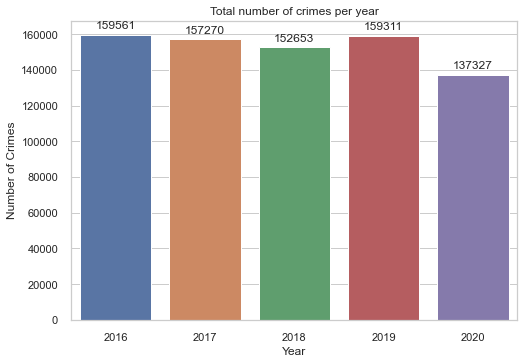

In [911]:
data = df_crime.groupby(['year']).size().reset_index(name='numberofcrime')
ax = sns.barplot(x="year", y="numberofcrime", data=data)
ax.set(xlabel='Year', ylabel='Number of Crimes',
       title="Total number of crimes per year")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9), textcoords='offset points')
plt.show()


+ **Total number of crimes per year by crime categories**

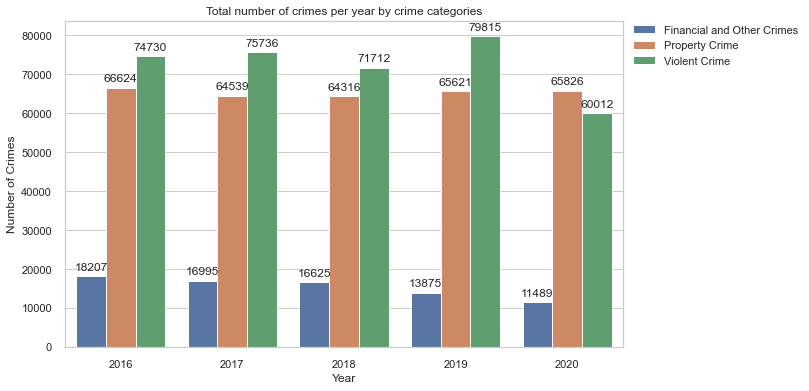

In [912]:
data = df_crime.groupby(['crime_category', 'year']
                        ).size().reset_index(name='numberofcrime')
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="year", y="numberofcrime",
            hue="crime_category", data=data, ax=ax)
ax.set(xlabel='Year', ylabel='Number of Crimes',
       title="Total number of crimes per year by crime categories")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9), textcoords='offset points')
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.show()


+ **Average number of crimes per neighborhood**, we select only top 10 and bottom 10.

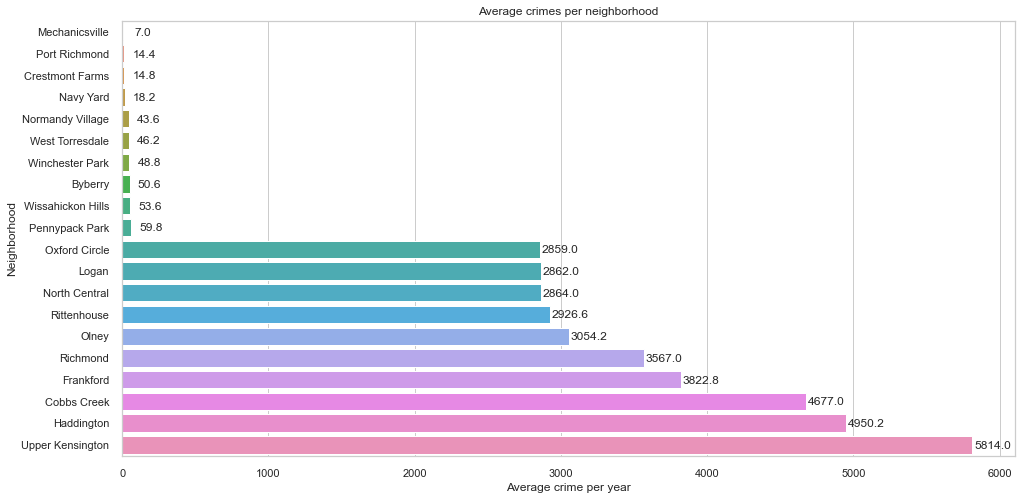

In [913]:
data = df_crime.groupby(['neighborhood']).size(
).reset_index(name='numberofcrime')
data['numberofcrime'] /= 5
data = data.sort_values(by=['numberofcrime'])
data_describe = pd.concat([data.head(10), data.tail(10)])
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x="numberofcrime", y="neighborhood", data=data_describe, ax=ax)
ax.set(xlabel='Average crime per year', ylabel='Neighborhood',
       title="Average crimes per neighborhood")
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.1f'),
                (p.get_width() + p.get_x(), p.get_y() + p.get_height()),
                ha='center', va='center',
                xytext=(20, 8), textcoords='offset points')
plt.show()


+ **Choropleth crime map of Philly**

In [914]:
data = pd.merge(df_philly, data, on='neighborhood')


In [915]:
map_choropleth_crime_philly = folium.Map(
    location=[geo_philly.latitude, geo_philly.longitude], zoom_start=11)
folium.Choropleth(
    geo_data=data,
    data=data,
    columns=['neighborhood', 'numberofcrime'],
    key_on='feature.properties.neighborhood',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Crimes in Philly (2016-2020)'
).add_to(map_choropleth_crime_philly)

# add neighborhood markers to map
folium.GeoJson(
    data,
    style_function=lambda x: {'color': '#00000000'},
    tooltip=folium.GeoJsonTooltip(fields=['neighborhood', 'numberofcrime'],
                                  aliases=['Neighborhood: ', 'Avg Crimes:']),
    popup=folium.GeoJsonPopup(fields=['neighborhood'], labels=False)
).add_to(map_choropleth_crime_philly)

map_choropleth_crime_philly


## **3.2 Featuring and clustering**

This step simply to make your data better suited to the problem at hand, determine which features are the most important with mutual information.

### **3.2.1 Features selection**

### **Venues Data**

We focus on 3 important venue categories: `Food`, `Medical Center`, `Shop & Service`, so we group them into 1 feature `Importance Venues`

In [916]:
df_venues_features = df_venues.loc[df_venues['venue_category'].isin(
    ['Food', 'Medical Center', 'Shop & Service'])]
df_venues_features = df_venues_features[['neighborhood', 'venue']]
df_venues_features = df_venues_features.groupby(
    'neighborhood').size().reset_index(name='Importance Venues')
df_venues_features.head(2)


,neighborhood,Importance Venues
0,Academy Gardens,31
1,Airport,5


### **Crime Data**

One-hot encoding creates new columns indicating the presence (or absence) of each possible value in the original data. We have only `3 crime categories` and `4 years`, that perfect to use `one-hot encoding` to encode them into different data columns.

In [917]:
# one hot encoding the crime category
df_crime_features = df_crime[['neighborhood', 'crime_category', 'year']]
df_crime_features = pd.get_dummies(data=df_crime_features, columns=[
                                   'crime_category', 'year'], prefix='', prefix_sep='')
print(df_crime_features.shape)
df_crime_features.head(1)


(766122, 9)


,neighborhood,Financial and Other Crimes,Property Crime,Violent Crime,2016,2017,2018,2019,2020
0,Industrial,0,1,0,0,0,1,0,0


Now, we calculte the total number of crime per neighborhood.

In [918]:
# group data by neiborhood
df_crime_features = df_crime_features.groupby('neighborhood').aggregate('sum')
print(df_crime_features.shape)
df_crime_features.head(1)


(158, 8)


,Financial and Other Crimes,Property Crime,Violent Crime,2016,2017,2018,2019,2020
neighborhood,,,,,,,,
Academy Gardens,138.0,449.0,319.0,230.0,174.0,160.0,173.0,169.0


We have data for each year, now we calculate the crime growth rate for each year.

In [919]:
# calculate average growth rate in 5 years
from statistics import mean
df_crime_features['Average Crime Growth Rate'] = sum([(df_crime_features[str(
    x+1)] - df_crime_features[str(x)]) / df_crime_features[str(x)]*100 for x in range(2016, 2020)])/5
print(df_crime_features.shape)
df_crime_features.head(1)


(158, 9)


,Financial and Other Crimes,Property Crime,Violent Crime,2016,2017,2018,2019,2020,Average Crime Growth Rate
neighborhood,,,,,,,,,
Academy Gardens,138.0,449.0,319.0,230.0,174.0,160.0,173.0,169.0,-5.316188


In [920]:
df_crime_features.drop(columns=[str(i) for i in range(2016, 2021)], inplace=True)
df_crime_features.head()

,Financial and Other Crimes,Property Crime,Violent Crime,Average Crime Growth Rate
neighborhood,,,,
Academy Gardens,138.0,449.0,319.0,-5.316188
Airport,563.0,838.0,168.0,-0.028590
Allegheny West,852.0,3784.0,5475.0,-0.604790
Andorra,93.0,430.0,152.0,-6.051430
Aston-Woodbridge,131.0,423.0,353.0,-1.378933


Then we continue to calculate the average crime of each category.

In [921]:
# get average of each category
for col in ['Financial and Other Crimes', 'Property Crime', 'Violent Crime']:
    df_crime_features['Average '+col] = round(df_crime_features[col] / 5, 2)
    del df_crime_features[col]

print(df_crime_features.shape)
df_crime_features.head(1)


(158, 4)


,Average Crime Growth Rate,Average Financial and Other Crimes,Average Property Crime,Average Violent Crime
neighborhood,,,,
Academy Gardens,-5.316188,27.6,89.8,63.8


We pick `Property Crime` and `Violent Crime` to reduce the dimension. You can keep or pick anything else.

In [922]:
df_crime_features['Average Crimes'] = df_crime_features['Average Property Crime'] + \
    df_crime_features['Average Violent Crime']
df_crime_features = df_crime_features[[
    'Average Crime Growth Rate', 'Average Crimes']]
df_crime_features.head(1)


,Average Crime Growth Rate,Average Crimes
neighborhood,,
Academy Gardens,-5.316188,153.6


### **The final features**

In [923]:
# Merge 2 data set into 1
df_features = pd.merge(df_crime_features, df_venues_features, on=['neighborhood'], how="inner")
print(df_features.shape)
df_features.head(2)


(158, 4)


,neighborhood,Average Crime Growth Rate,Average Crimes,Importance Venues
0,Academy Gardens,-5.316188,153.6,31
1,Airport,-0.028590,201.2,5


### **3.2.1 Clustering**

In [924]:
df = df_features
df = df.set_index('neighborhood')
df.head(2)


,Average Crime Growth Rate,Average Crimes,Importance Venues
neighborhood,,,
Academy Gardens,-5.316188,153.6,31
Airport,-0.028590,201.2,5


In [925]:
df.describe()


,Average Crime Growth Rate,Average Crimes,Importance Venues
count,158.000000,158.000000,158.000000
mean,-0.658507,872.064557,38.379747
std,8.023244,922.286252,7.682893
min,-20.148801,6.000000,5.000000
25%,-4.397241,258.750000,35.000000
50%,-1.043142,515.500000,39.500000
75%,1.307416,1324.600000,44.000000
max,77.450739,5309.600000,49.000000


Figure out the best K for KMeans.

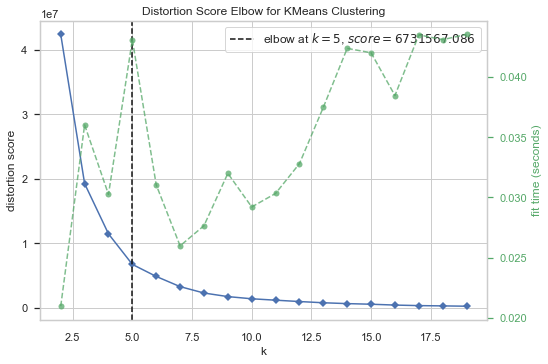

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [926]:
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans()
# k: Number of cluster to be attempted
visualizer = KElbowVisualizer(kmeans, k=(2, 20))
visualizer.fit(df)
visualizer.poof()


**Clustering with k = 5**

In [927]:
kmeans = KMeans(n_clusters=5)
df['cluster'] = kmeans.fit_predict(df)
# avoid zero cluster
df['cluster'] = df['cluster']+1
df.head()


,Average Crime Growth Rate,Average Crimes,Importance Venues,cluster
neighborhood,,,,
Academy Gardens,-5.316188,153.6,31,3
Airport,-0.028590,201.2,5,3
Allegheny West,-0.604790,1851.8,48,5
Andorra,-6.051430,116.4,37,3
Aston-Woodbridge,-1.378933,155.2,33,3


Overview number of neighborhood per cluster.

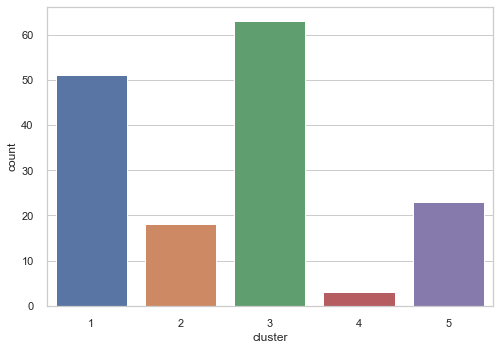

In [928]:
sns.countplot(x='cluster', data=df)
plt.show()


Visualize the clusters with PCA method.

In [929]:
pca = PCA(n_components=3)
fond = df.drop(['cluster'], axis=1)
df['pca_x'] = pca.fit_transform(fond)[:, 0]
df['pca_y'] = pca.fit_transform(fond)[:, 1]


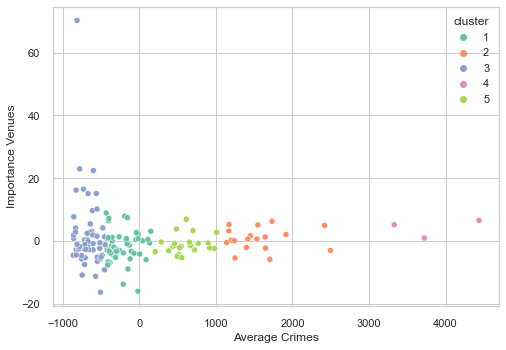

In [930]:
ax = sns.scatterplot(x=df['pca_x'], y=df['pca_y'],
                     hue=df.cluster, palette="Set2")
ax.set(xlabel='Average Crimes', ylabel='Importance Venues')
plt.show()


A better look with 3D Scatter visualization.

In [931]:
# 3d scatterplot using plotly
Scene = dict(xaxis=dict(title='Average Crimes -->'),
             yaxis=dict(title='Importance Venues -->'),
             zaxis=dict(title='Average Crime Growth Rate -->'))

labels = df['cluster']
trace = go.Scatter3d(x=df['Average Crimes'],
                     y=df['Importance Venues'],
                     z=df['Average Crime Growth Rate'],
                     mode='markers',
                     marker=dict(color=labels, size=10, line=dict(color='black', width=10)))
layout = go.Layout(margin=dict(l=0, r=0), scene=Scene, height=800, width=800)
data = [trace]
fig = go.Figure(data=data, layout=layout)
fig.show()


In [932]:
# remove pca columns
df.drop(columns=['pca_x', 'pca_y'], inplace=True)
df.reset_index(level=0, inplace=True)


# 4. Results and Discussion <a name="results"></a>

Based on those scatter charts above, we have 5 clusters:
+ **Cluster 3**: the biggest cluster with the least number of crimes, but still have a lot of venues, the crime growth rate is acceptable
+ **Cluster 1**: the second biggest cluster, the average crime is larger than the cluster 3, the crime growth rate and number of venues is not big different with cluster 3
+ **Cluster 5**: everything is in the middle of all average.
+ **Cluster 2**: the average number of crimes is above 50% of the average crime in the city, but they have a lot of important venues.
+ **Cluster 4**: the smallest cluster with the highest average crime, the highest crime growth rate

So we found that `cluster 3` is the target to do more analysis.

## Analysis neighborhoods in `Cluster 3`

We get top 20 of this cluster based on the `Average Crimes` to compare.

In [933]:
clus = df[df['cluster'] == 3]
del clus['cluster']
clus = clus.sort_values('Average Crimes').reset_index(drop=True)
print(clus.shape)
clus = clus.head(20)
clus


(63, 4)


,neighborhood,Average Crime Growth Rate,Average Crimes,Importance Venues
0,Mechanicsville,-8.730159,6.0,29
1,Port Richmond,1.841270,10.8,35
2,Navy Yard,-0.502541,12.8,33
3,Crestmont Farms,11.743590,13.6,41
4,Normandy Village,3.808289,36.6,34
5,Winchester Park,3.429699,38.4,36
6,Byberry,-4.613179,43.8,33
7,West Torresdale,12.035984,44.6,24
8,Wissahickon Hills,-3.313755,47.2,39
9,Woodland Terrace,3.842754,56.2,45


Visualize data to compare.

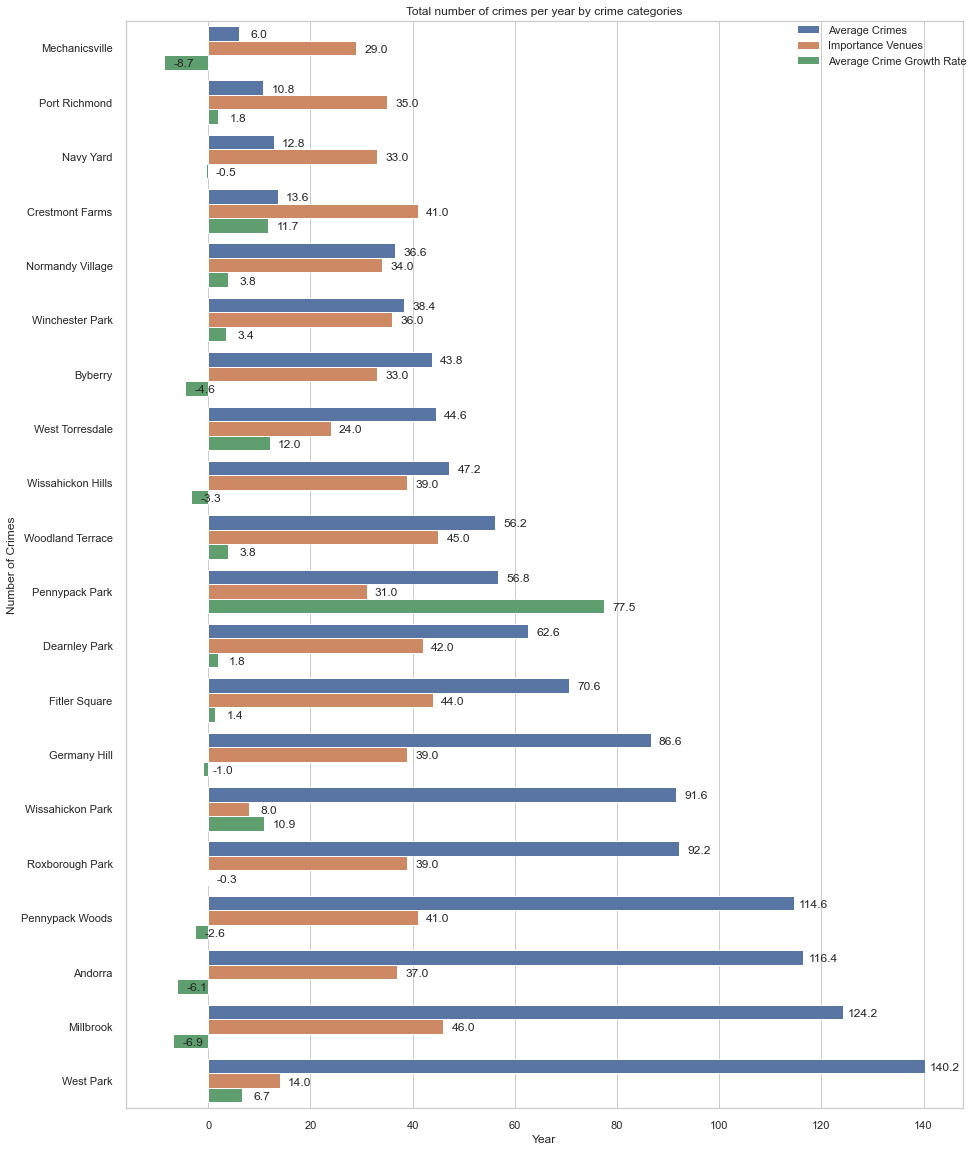

In [934]:
data = pd.melt(clus, id_vars=['neighborhood'], value_vars=[
               'Average Crimes', 'Importance Venues', 'Average Crime Growth Rate'], var_name='category')
fig, ax = plt.subplots(figsize=(15, 20))
sns.barplot(x='value', y='neighborhood', hue='category', data=data, ax=ax)
ax.set(xlabel='Year', ylabel='Number of Crimes',
       title="Total number of crimes per year by crime categories")
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.1f'),
                (p.get_width() + p.get_x(), p.get_y() + p.get_height()),
                ha='center', va='center',
                xytext=(20, 6), textcoords='offset points')
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.show()


**After all, we found top 5 neighborhood which will be the safe place to live in Philadelphia.**

In [935]:
clus.head(5)

,neighborhood,Average Crime Growth Rate,Average Crimes,Importance Venues
0,Mechanicsville,-8.730159,6.0,29
1,Port Richmond,1.841270,10.8,35
2,Navy Yard,-0.502541,12.8,33
3,Crestmont Farms,11.743590,13.6,41
4,Normandy Village,3.808289,36.6,34


# 5. Conclusion <a name="conclusion"></a>

The purpose of this project was to identify Philadelphia areas that will be a safe place to live with the lowest number of crimes, but there are still have a lot of important venues for your life. Clustering of those locations was then performed to create major zones of interest and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

The final decision on optimal location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors.